# CSE 5243 - Introduction to Data Mining
## Homework 2: Classification
- Semester: Fall 2022
- Instructor: Greg Ryslik
- Section: Wednesday 12:45
- Student Name: Karthik Prabhu
- Name.#: karthikprabhu22@gmail.com
***

# Introduction

### Objectives

In this lab, you will use the "Cleveland Data CLEANED AND TRIMMED.csv" heart disease dataset provided on Carmen.  It is a subset of the "Cleveland" dataset that can be found here: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

You will configure, execute, and evaluate an off-the-shelf K-Nearest-Neighbor classifier and two other classifiers you choose.

The objectives of this assignment are:
1.	Understand how to evaluate classifiers based on business criteria.
2.	Understand how to tune and evaluate a classifier to achieve good performance.
3.	Understand how to select and evaluate suitable off-the-shelf classifiers based on the characteristics of a dataset and the outcomes you need.

### Problem Statement

You work for a medical institution that wants to improve the heart health of its patients.  You have obtained a dataset that contains a variety of demographic and health-related information for a group of patients.  It also includes a CLASS variable "num" that indicates the heart health of each of the patients.  The values are:

0. No heart health issues / risk
1. Slight heart health issues / risk
2. Moderate heart health issues / risk
3. High heart health issues / risk
4. Extreme heart health issue / risk

You have been asked to develop a classifier based on the dataset data, to predict the CLASS of new patients so they can be enrolled in interventions based on their demographic data.

The COSTs of the interventions are as follows, based on the predicted class of each patient

0) Tiny intervention: 100 (dollars)
1) Minor intervention: 200
2) Moderate intervention: 300
3) Significant intervention: 400
4) Extreme intervention: 500

The BENEFITs of the interventions are as follows:

- If the classification is correct and the correct intervention given to the patient: 500 * (TRUE_CLASS + 1)
- If an incorrect classification is made and the wrong intervention is given to the patient: 0

You would like to find a classifier that maximizes the overall **NET_BENEFIT = BENEFIT - COST**. Therefore, a larger positive number is a good outcome.

So, for example:

- If a patient's true class is 4 and their predicted class is 0, their NET_BENEFIT = 0 - 100 = -100
- If a patient's true class is 4 and they are correctly classified, their NET_BENEFIT is 500*(4+1) - 500 = 2000

The medical institution would like you to evaluate the use of a K-Nearest-Neighbor classifier as a starting point.  You agree to do so, as long as you then can choose a different classifier if you are not satisfied with KNN.

***

***
# Section: Overview
- Insert a short description of the scope of this exercise, any supporting information, etc.
***

***
# Section: Setup
- Add any needed imports, helper functions, etc., here.
***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

sns.set_style('whitegrid')
df = pd.read_csv("Cleveland Data CLEANED AND TRIMMED.csv",index_col=0)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
id,,,,,,,,,,,,,,
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,39,0,3,138,220,0,0,152,0,0.0,2,0,3,0
279,57,1,2,154,232,0,2,164,0,0.0,1,1,3,1
280,58,0,4,130,197,0,0,131,0,0.6,2,0,3,0


***
# Section: 1 - Evaluation Method
- Define measures for evaluating the classification models you develop.  Explain why the measures you choose provide a useful view into the value and usefulness of the model you eventually chose for the company to use.  Define two types:
***

***
## Section: 1.1 - Define measures that do not include the cost information
- (e.g., confusion matrices, accuracy, precision, recall, F-measures, etc.).
- Consider using: from sklearn.metrics import classification_report, confusion_matrix
***

In [2]:
from sklearn.metrics import confusion_matrix, f1_score

### Accuracy score
Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true. 

$$\text { Accuracy }=\frac{\text { Number of correct predictions }}{\text { Total number of predictions }}$$

Accuracy alone doesn't tell the full story when you're working with a class-imbalanced data set, where there is a significant disparity between the number of positive and negative labels.


### F1-Score
Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that were retrieved.

$$\text { Precision }=\frac{T P}{T P+F P}$$

$$\text { Recall }=\frac{T P}{T P+F N}$$

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa. The formula for the F1 score is:

$$F_1 \text {-Score }=\frac{2 \text {-Precision }-\text { Recall }}{\text { Precision }+\text { Recall }}$$


***
## Section: 1.2 - Define measures that do include the cost information
- (e.g., using cost matrices).
- Consider creating a function that takes a confusion matrix and calculates the cost, like this:
***

In [3]:
cost_matrix = [[ 400., -200., -300., -400., -500.],   # 0
               [-100.,  800., -300., -400., -500.],   # 1
               [-100., -200., 1200., -400., -500.],   # 2  TRUE VALUES
               [-100., -200., -300.,  1600, -500.],   # 3
               [-100., -200., -300., -400., 2000]]   # 4
                   

def calculate_net_benefit(model, X, y):
  y_pred = model.predict(X)
  total = np.dot(np.array(confusion_matrix(y,y_pred)).ravel(), np.array(cost_matrix).ravel())
  return total

***
# Section: 2 - Pre-Processing of the Dataset
- Use the provided dataset.  Split it into a Training dataset and a Test dataset based on the class attribute.  Keep them separate and use the Training dataset for training/tuning and the Test dataset for testing. For consistency, use the **train_test_split** operation available in SciKit Learn (use a specific random seed, so it is reproducible).
  - from sklearn.model_selection import train_test_split
  - X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
***

***
## Section: 2.1 - Explore the attributes
- As in Homework 1, explore the attributes briefly. Reference the website listed in the Introduction.
- Provide basic statistics for the attributes.
- List which attributes are Nominal (even though they are encoded as numbers), Ordinal, Interval, Ratio.
***

Reference: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Attributes used are:
1.  (age) age: age in years
2.  (sex) sex (1 = male; 0 = female)
3.  (cp) chest pain type
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic
4.  (trestbps) resting blood pressure (in mm Hg on admission to the hospital) (Nominal: 120/80)
5.  (chol) serum cholesterol in mg/dl (<130)
6.  (fbs) (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7.  (restecg)  resting electrocardiographic results
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8.  (thalach) : maximum heart rate achieved
9.  (exang) exercise induced angina (1 = yes; 0 = no)
10. (oldpeak) ST depression induced by exercise relative to rest
11. (slope) the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping
12. (ca) number of major vessels (0-3) colored by flourosopy 
13. (thal) 3 = normal; 6 = fixed defect; 7 = reversable defect
14. (num) (the predicted attribute)  diagnosis of heart disease (angiographic disease status)
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing


***
## Section: 2.2 - Revise the dataset
- Review the meanings of the attributes and consider removing redundant or (likely) irrelevant attributes, combining attributes, etc., to reduce the number of attributes.
- (You may choose to use techniques such as those you used in Homework 1 to analyze the impacts of individual attributes on the CLASS attribute, but you need not do a “deep” analysis.)
- Describe what you chose to do (and not do), and why.
***

In [4]:
#Check for missing data
df.isnull().values.any()

False

There are no missing data

In [5]:
#Dupliate data
duplicate = df[df.duplicated()]

print("Duplicate Rows :")

# Print the resultant Dataframe
duplicate


Duplicate Rows :


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
id,,,,,,,,,,,,,,


There are no duplicates

age             AxesSubplot(0.125,0.71587;0.352273x0.16413)
trestbps     AxesSubplot(0.547727,0.71587;0.352273x0.16413)
chol           AxesSubplot(0.125,0.518913;0.352273x0.16413)
thalach     AxesSubplot(0.547727,0.518913;0.352273x0.16413)
oldpeak        AxesSubplot(0.125,0.321957;0.352273x0.16413)
num         AxesSubplot(0.547727,0.321957;0.352273x0.16413)
dtype: object

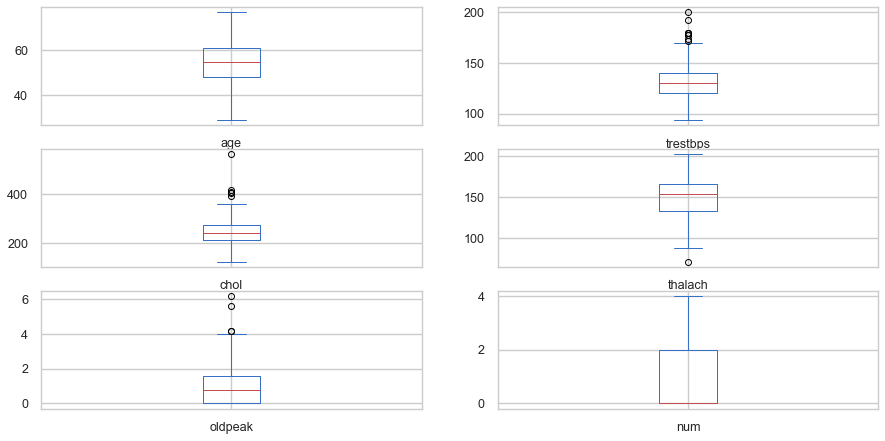

In [6]:
df_num = df[["age","trestbps", "chol", "thalach", "oldpeak", "num"]]
df_num.plot(subplots = True, layout = (4, 2), figsize = (15, 10), kind = "box", sharex = False)

There are no significant outliers. We can ignore the few outliers that exist.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 1 to 282
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       282 non-null    int64  
 1   sex       282 non-null    int64  
 2   cp        282 non-null    int64  
 3   trestbps  282 non-null    int64  
 4   chol      282 non-null    int64  
 5   fbs       282 non-null    int64  
 6   restecg   282 non-null    int64  
 7   thalach   282 non-null    int64  
 8   exang     282 non-null    int64  
 9   oldpeak   282 non-null    float64
 10  slope     282 non-null    int64  
 11  ca        282 non-null    int64  
 12  thal      282 non-null    int64  
 13  num       282 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.0 KB


In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,54.411348,0.677305,3.163121,131.563830,249.092199,0.148936,1.014184,149.765957,0.326241,1.026950,1.585106,0.595745,4.581560,0.907801
std,9.053083,0.468338,0.955405,17.757496,51.217546,0.356658,0.998118,22.923869,0.469670,1.138825,0.609700,1.236910,2.248467,1.224894
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,-9.000000,-9.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,244.000000,0.000000,2.000000,153.500000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,277.000000,0.000000,2.000000,165.750000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


<AxesSubplot:ylabel='num'>

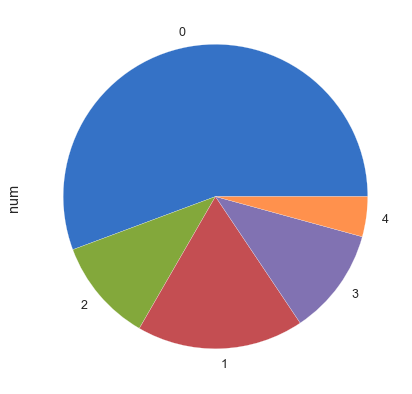

In [9]:
df.num.value_counts(sort=False).plot.pie()

The data set is not uniformly distributed among the different heart health groups. 

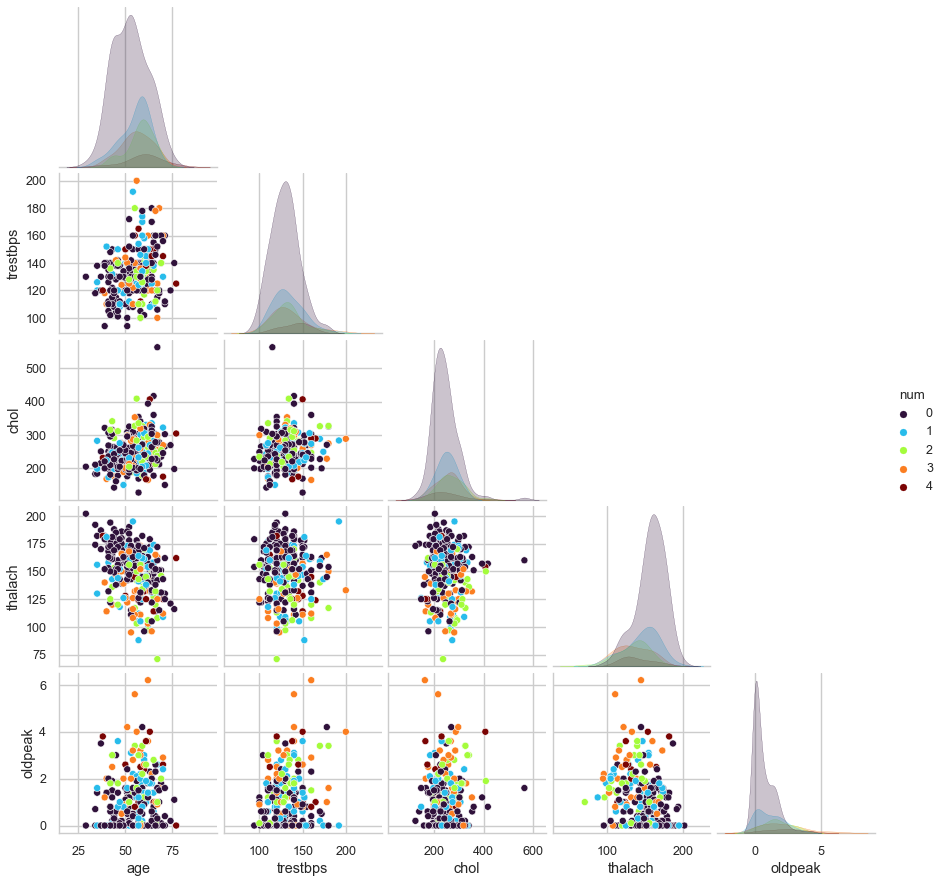

In [10]:
sns.pairplot(df_num,hue='num', diag_kind='kde', corner=True, palette='turbo')

We do not observe anything particularly interesting from this scatter plot.

<AxesSubplot:>

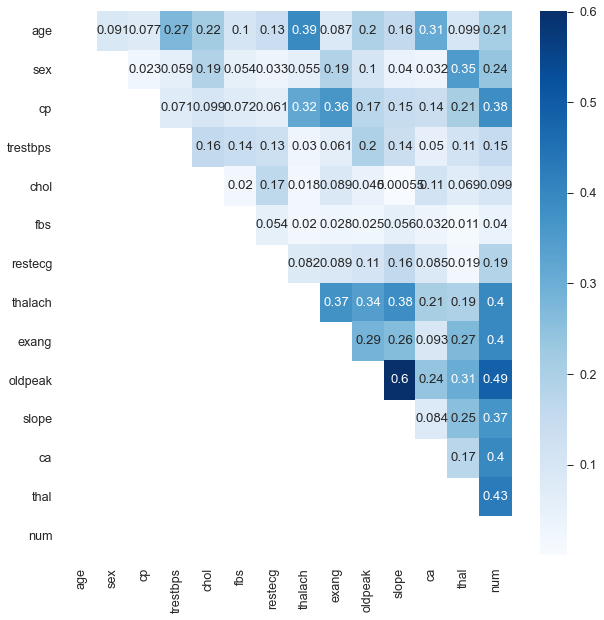

In [11]:
#Create correlation matrix
corr_matrix = df.corr().abs()

#Select upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

plt.figure(figsize=(10, 10))
sns.heatmap(upper, annot=True, cmap='Blues')


<AxesSubplot:>

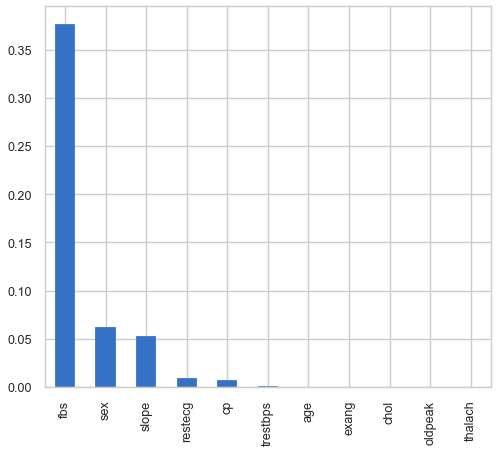

In [12]:
from sklearn.feature_selection import chi2
chi_scores = chi2(df.drop(columns=["ca","thal","num"]),df.num)
p_values = pd.Series(chi_scores[1], index=df.drop(columns=["ca", "thal","num"]).columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()


We observe that fbs has very low correlation with num (p-value = 0.38). Therefore we can ignore this variable.

In [13]:
df.drop(columns=["fbs"], inplace=True)

***
## Section: 2.3 - Transform the attributes
- Consider transforming the remaining attributes (e.g., using the data dictionary to replace the numbers with text values for some attributes – this might or might not be useful), normalizing / scaling values, encoding labels (if necessary), etc.
- Describe what you chose to do (and not do), and why.
***

Earlier I tested various classifiers without using the stratify as an argument to the train_test_split function. I noticed that it was not giving a good accuracy score which significantly improved after stratifying the data based on the outcome.

In [14]:
X = df.drop("num",axis=1)
y = df["num"]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

***
# Section: 3 - Evaluation of the Off-The-Shelf KNN Classifier
- Select the KNN classifier from the SciKit Learn library and run it on the dataset.
***

***
## Section: 3.1 - Configure the off-the-shelf KNN classifier
- Use the KNeighborsClassifier from the SciKit Learn library
- Explain all setup, parameters and execution options you chose to set, and why.
***

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


In [17]:
model = KNeighborsClassifier(n_neighbors=20, weights="distance")

I'm currently using the following configuration for the KNeighbors: n_neighbors=20, weights="distance".  As for the n_neighbors parameter, it decides how many nearest neighbors to use, and since we have ~280 data points and 5 classes, 20 seems like a reasonable number of neighbors to use. It makes sense to use a distance based weighting scheme rather than using uniform, since we expect the different datapoints to be clustered together based on their categories. 

***
## Section: 3.2 - Run and evaluate the classifier
- Try several values of the K parameter and compare the results.
- Evaluate the performance of the classifier, using the evaluation method you defined above.
***

Text(0.5, 0, 'k')

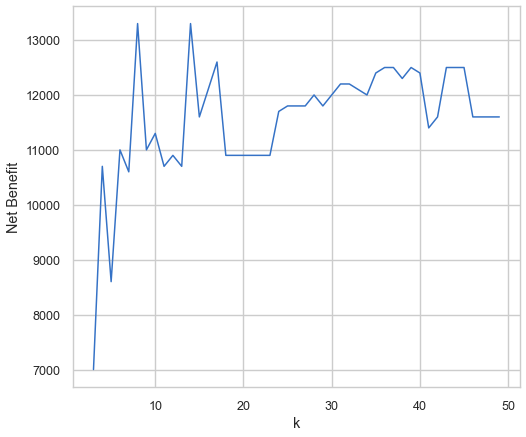

In [18]:
net_benefit_k = []
k_range = range(3,50)
for k in k_range:
  model = KNeighborsClassifier(k,weights="distance")
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  net_benefit_k.append(calculate_net_benefit(model, X_test, y_test))

plt.plot(k_range, net_benefit_k)
plt.ylabel("Net Benefit")
plt.xlabel("k")




It seems like that we get Max benefit for a k value = 8. Therefore, we proceed with n_neighbors=8 and evaluate the performance of KNeighbors Classifier.

In [19]:
knn_model = KNeighborsClassifier(8)
knn_model.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=8)

In [20]:
y_pred = knn_model.predict(X_test)


In [21]:
print("Accuracy = ", accuracy_score(y_test, y_pred))

Accuracy =  0.6140350877192983


In [22]:
print("Net benefit = ", calculate_net_benefit(knn_model, X_test, y_test))

Net benefit =  14100.0


***
## Section: 3.3 - Evaluate the choice of the KNN classifier
- What characteristics of the problem and data made KNN a good or bad choice?
***

The dataset is quite small is size with about 280 entries. This is perfect for KNN classifier as it has to use the entire dataset for every prediction. Calculate the distance between every pair of points becomes prohibitive for large datasets. 

However, we have several features (~13), and KNN assigns uniform weight to each of these features. This might result in overfitting and this classifier might not generalize well. This is apparent when I change the random seed for the train_test_split and I get very different *Net Benefit* and best k-value. 

***
# Section: 4 - Evaluation of Off-The-Shelf Classifier #2
- As with the KNN classifier above, choose another classifier from the SciKit Learn library (Decision Tree, SVM, Logistic Regression, etc.) and run it on the dataset.
***

***
## Section: 4.1 - Configure the classifier
- Use the appropriate classifier from the SciKit Learn library.
- Explain all setup, parameters and execution options you chose to set, and why.
***

In [23]:
svm_model = SVC(kernel="linear")

Here I tried playing with the various arguments of the SVC function and found that the default parameters work the best for most of the cases. I also found that changing the kernel to a linear gives a better performance than the default kernel which is Radial basis function or rbf. 

***
## Section: 4.2 - Run and evaluate the classifier
- Try several values of the parameters (if appropriate) and compare the results.
- Evaluate the performance of the classifier, using the evaluation method you defined above.
***

In [24]:
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [25]:
y_pred = svm_model.predict(X_test)

In [26]:
print("Accuracy = ", accuracy_score(y_test,y_pred))

Accuracy =  0.631578947368421


In [27]:
print("Net benefit = ", calculate_net_benefit(svm_model, X_test, y_test))

Net benefit =  13800.0


***
## Section: 4.3 - Evaluate the choice of the classifier
- What characteristics of the problem and data made the classifier a good or bad choice?
***

SVM works relatively well when there is a clear margin of separation between classes and the parameter space is high dimensional and our dataset is moderately high dimensional. SVM algorithm is not suitable for large data sets which is not a problem for our dataset.

SVM does not perform very well when the data set has more noise i.e. target classes are overlapping. This might be a problem for our dataset.

Source: https://dhirajkumarblog.medium.com/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107

***
# Section: 5 - Evaluation of Off-The-Shelf Classifier #3
- As with the KNN classifier above, choose another classifier from the SciKit Learn library (Decision Tree, SVM, Logistic Regression, etc.) and run it on the dataset.
***

***
## Section: 5.1 - Configure the classifier
- Use the appropriate classifier from the SciKit Learn library.
- Explain all setup, parameters and execution options you chose to set, and why.
***

In [28]:
logreg_model = LogisticRegression(max_iter=20000)

***
## Section: 5.2 - Run and evaluate the classifier
- Try several values of the parameters (if appropriate) and compare the results.
- Evaluate the performance of the classifier, using the evaluation method you defined above.
***

I tried playing around with different arguments of the logistic regression function such as solver type, penalty function and multiclass parameter. I found that it was best to use the default parameters of the logistic regression function which is the "lbfgs" solver with "l2-norm" penalty and multinomial loss fit. I only had to change the maximum iterations to 20000 for the solver to converge.

In [29]:
logreg_model.fit(X_train, y_train)


LogisticRegression(max_iter=20000)

In [30]:
y_pred = logreg_model.predict(X_test)


In [31]:
print("Accuracy = ", accuracy_score(y_test, y_pred))

Accuracy =  0.6140350877192983


In [32]:
print("Net benefit = ", calculate_net_benefit(logreg_model, X_test, y_test))


Net benefit =  11100.0


***
## Section: 5.3 - Evaluate the choice of the classifier
- What characteristics of the problem and data made the classifier a good or bad choice?
***

Logistic regression requires there to be a causal relation between predictor and the outcome which is true in our case. It doesn't require high computation power, is easy to implement, easily interpretable. Also, it doesn't require scaling of features. It also provides a probability score for observations.

Logistic regression is not able to handle a large number of categorical features/variables. It is vulnerable to overfitting. Also, can't solve the non-linear problem with the logistic regression that is why it requires a transformation of non-linear features. Logistic regression will not perform well with variables that are not correlated to the target variable but we have taken care of that by removing such predictor variables. It also performs poorly when the predictor variables are very similar or correlated to each other.

***
# Section: 6 - Comparison of the Three Classifiers
***

***
## Section: 6.1 - Compare the performance of these classifiers to each other
- What are their strong and weak points?
***

### Strong points:
- KNN: Simple model, easy to interpret, no training needed, 
- SVM: Overcomes problems of overfitting, finds the optimal hyperplane that divides the data into categories.
- Logistic regression: Easy to interpret, explores the linear dependence of the outcome on the predictor variables.

### Weak points:
- KNN: Overfits the data, Need to scale the data,
- SVM: Doesn't work well when the outcome classes are overlapping
- Logistic Regression: Assumes a causal dependence between the outcome and the predictor variables, vulnerable to overfitting.

***
## Section: 6.2 - Choose a Best Classifier
- Choose one of the three classifiers as best and explain why.
***

In [33]:
classification_models = []
classification_models.append(
    ('Logistic Regression', logreg_model))
classification_models.append(('K Nearest Neighbor', knn_model))
classification_models.append(('Linear SVM', svm_model))


for name, model in classification_models:
  kfold = KFold(n_splits=5, random_state=7, shuffle=True)
  result = cross_val_score(model, X, y, cv=kfold, scoring=     calculate_net_benefit)
  print("%s: Mean Net Benefit = %.2f - SD Net Benefit = %.2f" %
        (name, result.mean(), result.std()))        


Logistic Regression: Mean Net Benefit = 9280.00 - SD Net Benefit = 3040.66
K Nearest Neighbor: Mean Net Benefit = 8300.00 - SD Net Benefit = 1294.60
Linear SVM: Mean Net Benefit = 9840.00 - SD Net Benefit = 2689.68


- If we choose a cost-independent metric like accuracy, then we find that Logistic regression and Knn classifier performed best with 61% accuracy.
- If we choose a cost-dependent metric like Net Benefit, then we find that Knn classifier performed best with a Net Benefit = 14100.0
- Finally, we also want our model to be generalizable. Using cross validation with Net Benefit as the scoring metric, we find Linear SVM to be the best model with mean benefit of 9840.

***
# Section: 7 - Conclusions
- Write a paragraph on what you discovered or learned from this homework.
***

- The choice of the best classifier method is highly dependent on the dataset as well as the scoring metric that we choose. 
- KNN is a simple and easy to interpret classifier that can perform well for simple datasets with well separated target classes and fewer features.
- Logistic regression is suitable when you have some apriori knowledge about the outcome being causally dependent on some linear combination of predictor variables.
- Finally, SVM is the most generalizable classifier that can find the most optimal hyperplane that separates the target clusters.
- I would recommend the stake holders, the linear kernel SVM model which as we have shown maximizes the Net Benefit.

# Limitations of KNN:
KNN is a very powerful algorithm. It is also called “lazy learner”. However, it has the following set of limitations:

1. Doesn’t work well with a large dataset:

Since KNN is a distance-based algorithm, the cost of calculating distance between a new point and each existing point is very high which in turn degrades the performance of the algorithm.

2. Doesn’t work well with a high number of dimensions:

Again, the same reason as above. In higher dimensional space, the cost to calculate distance becomes expensive and hence impacts the performance.

3. Sensitive to outliers and missing values:

KNN is sensitive to outliers and missing values and hence we first need to impute the missing values and get rid of the outliers before applying the KNN algorithm.

# Limitations of SVM 
1) SVMs are not suitable for large datasets
The complexity of the algorithm’s training is highly dependent on the size of the dataset. In other words, training time grows with the dataset to a point where it becomes infeasible to train and use due to compute constraints.

2) SVMs perform poorly in imbalanced datasets
There are two more well-attributed reasons for this. The first being the weakness of the soft margin optimization problem. This results in the hyperplanes being skewed to the minority class when imbalanced data is used for training.

The second reason arises from the issue of an imbalanced support vector ratio, i.e. the ratio between the positive and negative support vectors becoming imbalanced and as a result, datapoints at the decision boundaries of the hyperplanes have a higher chance of being classified as negative.

3) SVMs with the ‘wrong’ kernel
This is a somewhat intuitive one. For SVMs nowadays, choosing the right kernel function is key. As an example, using the linear kernel when the data are not linearly separable results in the algorithm performing poorly. However, choosing the ‘right’ kernel is another problem on its own, which among the techniques used, popular ones include varying the kernel function in the hyperparameter search.

4) When there is just too much noise in the data
In these cases of noisy data, target classes are overlapping, in the sense that the features can have very similar or overlapping properties. This possibly results in arriving at several local optima due to the nature of the optimization algorithm, especially for high dimensional datasets.

# Limitations of logistic regression
### Choosing the right predictor variables
The key to a successful logistic regression model is to choose the correct variables to enter into the model. While it is tempting to include as many input variables as possible, this can dilute true associations and lead to large standard errors with wide and imprecise confidence intervals, or, conversely, identify spurious associations. The conventional technique is to first run the univariate analyses (i.e., relation of the outcome with each predictor, one at a time) and then use only those variables which meet a preset cutoff for significance to run a multivariable model. This cutoff is often more liberal than the conventional cutoff for significance (e.g., P < 0.10, instead of the usual P < 0.05) since its purpose is to identify potential predictor variables rather than to test a hypothesis. In addition, one needs to consider the scientific plausibility and the clinical meaningfulness of the association. For instance, univariate analyses for risk factors for myocardial infarction may show that gray hair and baldness are associated with the occurrence of disease. However, these associations are scientifically implausible (and are due to association of these findings with older age and male sex, respectively) and hence must not be entered into a logistic regression analysis.

### Avoiding the use of highly correlated variables
If input variables are highly correlated with one another (known as multicollinearity), then the effect of each on the regression model becomes less precise. Let us consider a model where both height and body surface area have been used as input variables to predict the risk of developing hypertension. Because body surface area depends on and therefore, has a high correlation with height, the effect of height on hypertension will get split between the two variables (and hence diluted). In such cases, the regression model should include only one of the two or more inter-related predictors.

#### Restricting the number of variables entered into a multivariate logistic regression model?
It has been suggested that the data should contain at least ten events for each variable entered into a logistic regression model. Hence, if we wish to find predictors of mortality using a sample in which there have been sixty deaths, we can study no more than 6 (=60/10) predictor variables. However, the validity of this thumb rule has been questioned.

#### Odds versus risk
It must be remembered that logistic regression provides aORs for each predictor. The odds differ from the risk, and while the odds may appear to be high, the absolute risk may be low.

#### Handling continuous input variables
For continuous data (e.g., age, height, or weight), it is tempting to divide the subjects into categories (e.g., age >50 years vs. age ≤50 years). This is not a good practice since the cutoffs tend to be arbitrary and part of the information is lost.

#### Assumptions regarding the relationship between input and output variables
Regression models assume that the relationship between the predictor variables and the dependent variable is uniform, i.e., follows a particular direction – this may be positive or negative, linear or nonlinear but is constant over the entire range of values. This assumption may not hold true for certain associations – for example, mortality from pneumonia may be higher at both extremes of age. Therefore, calculating aORs for age as a predictor of mortality from pneumonia will not give valid results if the ages extended from neonates to the elderly. Furthermore, regression equations derived from a specific set of patients (e.g., in a developed country with advanced medical care) may not apply to patients with different characteristics (e.g., in areas without intensive care units).

***
### END-OF-SUBMISSION
***